# Hybrid quantum-classical polarizability model for single molecule biosensing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator

In [2]:
cm = 1/2.54

def filter_data(solvent_data, gas_labels, usecols):
    """Function to sort and filter data from slurm array jobs."""
    solvent_results = np.genfromtxt(f'./results/{solvent_data}.dat', skip_header=2, usecols=usecols)
    solvent_labels = np.genfromtxt(f'./results/{solvent_data}.dat', skip_header=2, usecols=[0], dtype='str')
    
    _, idx, _ = np.intersect1d(
        sorted(solvent_labels), 
        sorted(gas_labels), 
        assume_unique=False, 
        return_indices=True)
    
    solvent_sorted = solvent_results[np.argsort(solvent_labels)][idx]
    return solvent_sorted


def plot_alpha_ph(alpha, pka, ax, k=2.5, color='k', linestyle='-', label='Polarizability'): 
    """ Function to plot polarizability as a function of pH. 
    Input: 
    alpha - polarizability for different protonation states
    pka - pka values
    ax - define matplotlib axis
    """
    na  = len(pka)
    
    pka_midp = []
    for i in range(na-1):
        pka_midp.append((pka[i] + pka[i+1]) / 2)
    pka_midp.append(14)
    pka_midp.insert(0, 0)
    
    y_amp = []
    y_shift = []
    for i in range(len(alpha)-1):
        y_amp.append((alpha[i+1] - alpha[i])/2)
        y_shift.append((alpha[i] + alpha[i+1])/2)
        
    x = []
    y = []
    for i in range(na):
        num = int(np.rint(abs(pka_midp[i+1] - pka_midp[i]) * 10))
        xi = np.linspace(pka_midp[i], pka_midp[i+1], num)
        yi = y_amp[i] * np.tanh((xi-pka[i]) * k) + y_shift[i]
        x.extend(xi)
        y.extend(yi)
    ax.plot(x, y, color=color, label=label, linestyle=linestyle)
    return


def read_alphaml_data(alphaml):
    """Convert alphaml results to isotropic polarizability list in [Ang**3]."""
    alphaml_data = np.genfromtxt(f'./results/{alphaml}.dat', skip_header=2, usecols=[2, 3, 4, 5, 6, 7])
    num = alphaml_data.shape[0]
    alphaml_list = np.zeros(num)
    for i in range(num):
        alphaml_cc = np.zeros((3, 3))
        np.fill_diagonal(alphaml_cc, alphaml_data[i][0:3])
        alphaml_cc[0, 1] = alphaml_cc[1, 0] = alphaml_data[i][3]
        alphaml_cc[0, 2] = alphaml_cc[2, 0] = alphaml_data[i][4]
        alphaml_cc[1, 2] = alphaml_cc[2, 1] = alphaml_data[i][5]
        # diagonalize, convert Bohr to Angstrom
        w, _ = np.linalg.eig(alphaml_cc * (0.529177)**3)
        alphaml = w.sum() / 3
        alphaml_list[i] = alphaml
    return alphaml_list

## Effective polarizability and fractional anisotropy

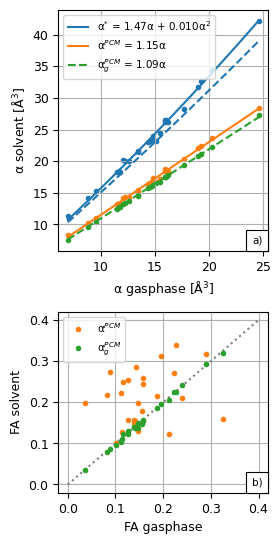

In [20]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(7.3*cm, 14*cm), gridspec_kw={'height_ratios': [4, 3]})

# PLOT-A: polarizability
alpha_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[2])
gas_labels = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[0], dtype='str')
alpha_gas = alpha_gas[np.argsort(gas_labels)]

# gasphase structures in solvent
alpha_gas_pcm = filter_data('alpha_gas_pcm', gas_labels, usecols=[2])
# solvent structures in solvent
alpha_pcm = filter_data('alpha_pcm', gas_labels, usecols=[2])

# initial guess for self-consistent polarizability
alpha_initial = filter_data('alpha_local_field', gas_labels, usecols=[2])
# self-consistent polarizability results
alpha_converged = filter_data('alpha_local_field', gas_labels, usecols=[3])

# plot best fit lines
x = np.linspace(np.amin(alpha_gas), np.amax(alpha_gas), 50)
# converged
ax1.plot(x, 1.47167*x + 0.00987*x**2, label='α$^{*}$ = 1.47α + 0.010α$^{2}$', color='tab:blue')
# initial guess
ax1.plot(x, 1.44978*x + 0.00541*x**2, linestyle='--', color='tab:blue')
# alpha pcm (solvent structures)
ax1.plot(x, 1.14982*x, label='α$^{PCM}$ = 1.15α', color='tab:orange')
# alpha pcm (gasphase structures)
ax1.plot(x, 1.09385*x, label='α$^{PCM}_{g}$ = 1.09α', linestyle='--', color='tab:green')

# plot data
ax1.scatter(alpha_gas, alpha_converged, marker='.', color='tab:blue')
ax1.scatter(alpha_gas, alpha_pcm, marker='.', color='tab:orange')
ax1.scatter(alpha_gas, alpha_gas_pcm, marker='.', color='tab:green')

ax1.set_xlabel('α gasphase [Å$^3$]')
ax1.set_ylabel('α solvent [Å$^3$]')
ax1.legend(fontsize='small', ncol=1, markerscale=0.5)
ax1.grid()

# PLOT-B: fractional anisotropy
fa_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[-1])
fa_gas = fa_gas[np.argsort(gas_labels)]

fa_gas_pcm = filter_data('alpha_gas_pcm', gas_labels, usecols=[-2])
fa_pcm = filter_data('alpha_pcm', gas_labels, usecols=[-2])

x = np.linspace(0, 0.4, 51)
ax2.plot(x, x, linestyle='dotted', color='tab:grey')
ax2.plot(fa_gas, fa_pcm, color='tab:orange', linestyle='', marker='.', label='α$^{PCM}$')
ax2.plot(fa_gas, fa_gas_pcm, color='tab:green', linestyle='', marker='.', label='α$^{PCM}_{g}$')

ax2.set_xlabel('FA gasphase')
ax2.set_ylabel('FA solvent')

ax2.set_yticks(np.arange(0, 0.5, 0.1))
ax2.set_xticks(np.arange(0, 0.5, 0.1))
ax2.legend(fontsize='small', ncol=1)
ax2.grid()

ax1.text(0.948, 0.064, 'a)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax1.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8),
        fontsize='small')

ax2.text(0.948, 0.086, 'b)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax2.transAxes,
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8),
        fontsize='small')

plt.rcParams.update({'font.size': 9})
plt.tight_layout()

#plt.savefig('solvgas.svg', format='svg', dpi=1200, bbox_inches='tight')

# Excess vs gasphase polarizability

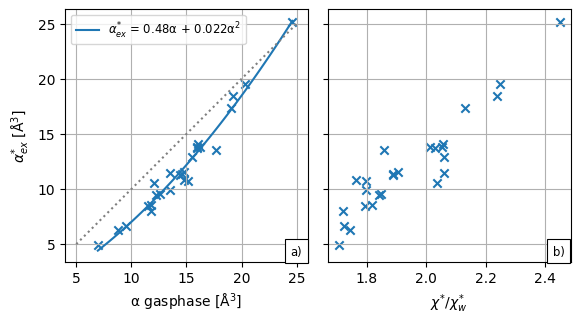

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15*cm, 8.5*cm), sharey=True)

# PLOT-A: polarizability
alpha_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[2])
gas_labels = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[0], dtype='str')
alpha_gas = alpha_gas[np.argsort(gas_labels)]

# excess polarizability
alpha_excess = filter_data('alpha_excess', gas_labels, usecols=[3])
x = np.linspace(np.amin(alpha_gas), np.amax(alpha_gas), 50)
# converged
ax1.plot(x, 0.479699*x + 0.022214*x**2, label='$α^{*}_{ex}$ = 0.48α + 0.022α$^{2}$', color='tab:blue')
ax1.scatter(alpha_gas, alpha_excess, marker='x', color='tab:blue')
ax1.set_xlabel('α gasphase [Å$^3$]')
ax1.set_ylabel('$α^{*}_{ex}$ [Å$^3$]')
ax1.legend(fontsize='small')
ax1.axis('equal')
ax1.set_yticks(np.arange(5., 30., 5.))

x = np.linspace(5, 25, 51)
ax1.plot(x, x, linestyle='dotted', color='tab:grey')
ax1.grid()

# polarizability density:
alpha_ast = filter_data('alpha_local_field', gas_labels, usecols=[3])
cavity_volume = filter_data('alpha_excess', gas_labels, usecols=[-1])
density = (alpha_ast / cavity_volume) / 0.0613
ax2.scatter(density, alpha_excess, marker='x', color='tab:blue')
ax2.grid()
ax2.set_xlabel('$χ^{*}/χ^{*}_w$')

ax1.text(0.952, 0.068, 'a)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax1.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8), 
        fontsize='small')

ax2.text(0.952, 0.068, 'b)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax2.transAxes,
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8),
        fontsize='small')


plt.tight_layout()


#plt.savefig('exgas.svg', format='svg', dpi=600, bbox_inches='tight')

1.9437070671753531
1.3679724038890724
-0.07166705020042209


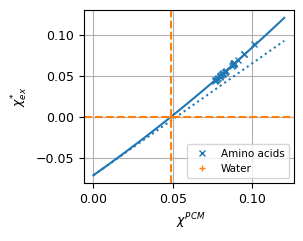

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8.3*cm, 6.3*cm))

# PLOT-A: polarizability
alpha_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[2])
gas_labels = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[0], dtype='str')
alpha_gas = alpha_gas[np.argsort(gas_labels)]

# excess polarizability density
alpha_excess = filter_data('alpha_excess', gas_labels, usecols=[2])
cavity_volume = filter_data('alpha_excess', gas_labels, usecols=[-1])

chi_excess = alpha_excess / cavity_volume

# PCM polarizability density
alpha_pcm = filter_data('alpha_pcm', gas_labels, usecols=[2])

chi_pcm = alpha_pcm / cavity_volume

# Best fit line
eps = 1.77
fc = 3 * eps / (2 * eps + 1)
fr = 8 * np.pi * (eps - 1) / (3 * (2 * eps + 1))
c = fc * (1 - eps) / (4 * np.pi) 

a = fc**2 * fr
b = fc**2

x = np.linspace(0.0, 0.12, 50)
y = fc**2 * fr * x**2 + fc**2 * x + c

#ax1.plot(x, y, label='$χ^{*}_{ex} = f^{C}(f^{C}f^{R} (χ^{PCM})^{2} + f^{C} χ^{PCM} + (1-ε)/4π $', color='tab:blue')
ax1.plot(x, y, color='tab:blue')
ax1.plot(x, fc**2 * x + c, color='tab:blue', linestyle='dotted')
ax1.plot(chi_pcm, chi_excess, marker='x', color='tab:blue', label='Amino acids', linestyle='None', markersize=4)
ax1.axhline(y=0.0, color='tab:orange', linestyle='--')
ax1.axvline(x=0.0488, color='tab:orange', linestyle='--')
ax1.plot(0.0488, 0.0, marker='+', color='tab:orange', label='Water', linestyle='None', markersize=4)

ax1.set_xlabel(' $χ^{PCM}$')
ax1.set_ylabel('$χ^{*}_{ex}$')
#ax1.axis('equal')
ax1.legend(fontsize='small')
ax1.grid()
#ax1.set_xticks(np.arange(0.0, 0.12, 0.02))

plt.rcParams.update({'font.size': 9})

plt.tight_layout()

#plt.savefig('excess_density.svg', format='svg', dpi=600, bbox_inches='tight')
print(a)
print(b)
print(c)

In [3]:
eps = 1.77
fc = 3 * eps / (2 * eps + 1)
fr = 8 * np.pi * (eps - 1) / (3 * (2 * eps + 1))
c = fc * (1 - eps) / (4 * np.pi) 

a = fc**2 * fr
b = fc**2 - 1

y1 = (-b + (b**2 - 4 * a * c)**(0.5)) / (2 * a)
y2 = (-b - (b**2 - 4 * a * c)**(0.5)) / (2 * a)

print(y1)
print(y2)

0.1194251838870043
-0.3087399268867402


Text(0.5, 0, 'V [Å$^3$]')

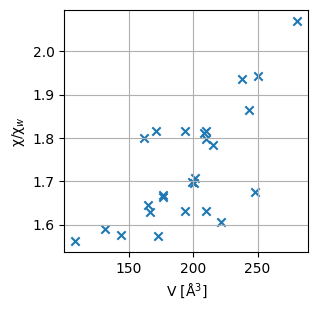

In [4]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8*cm, 8*cm), sharey=True)

# polarizability density:
gas_labels = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[0], dtype='str')
alpha_pcm = filter_data('alpha_pcm', gas_labels, usecols=[2])
cavity_volume = filter_data('alpha_pcm', gas_labels, usecols=[-1])
density = (alpha_pcm / cavity_volume) / 0.04876
ax1.scatter(cavity_volume, density, marker='x', color='tab:blue')
ax1.grid()
ax1.set_ylabel('χ/χ$_w$')
ax1.set_xlabel('V [Å$^3$]')

# Excess polarizability (numerical vs quantum-classical)

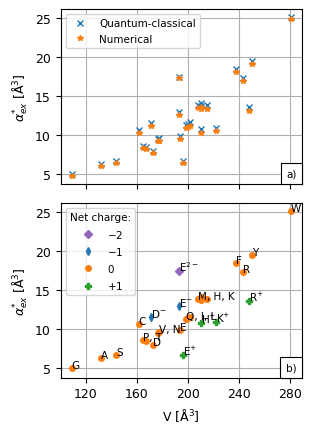

In [51]:
cavity_volume = np.genfromtxt('./results/alpha_excess.dat', usecols=[-1], skip_header=2)
alpha_numerical = np.genfromtxt('./results/alpha_excess.dat', usecols=[2], skip_header=2)
alpha_excess = np.genfromtxt('./results/alpha_excess.dat', usecols=[3], skip_header=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.1*cm, 11.2*cm), sharex=True, sharey=True)

# PLOT-A: compare numerical model and hybrid quantum-classical model
ax1.plot(cavity_volume, alpha_excess, label='Quantum-classical', marker='x', linestyle='', color='tab:blue', markersize=4)
ax1.plot(cavity_volume, alpha_numerical, label='Numerical', marker='*', linestyle='', color='tab:orange', markersize=4)

ax1.set_ylabel('$α^{*}_{ex}$ [Å$^3$]')
#ax1.set_xlabel('V [Å$^3$]')
ax1.grid()
ax1.legend(fontsize='small')
#ax1.set_title('a)')

# PLOT-B: amino acids catergorized according to net charge
net_charge = np.genfromtxt('./results/alpha_excess.dat', usecols=[1])
ax2.plot(cavity_volume[net_charge==-2], alpha_excess[net_charge==-2], label='$-2$', marker='D', linestyle='', color='tab:purple', markersize=4)
ax2.plot(cavity_volume[net_charge==-1], alpha_excess[net_charge==-1], label='$-1$', marker='d', linestyle='', color='tab:blue', markersize=4)
ax2.plot(cavity_volume[net_charge==0], alpha_excess[net_charge==0], label='$0$', marker='o', linestyle='', color='tab:orange', markersize=4)
ax2.plot(cavity_volume[net_charge==1], alpha_excess[net_charge==1], label='$+1$', marker='P', linestyle='', color='tab:green', markersize=4)

ax2.grid()
ax2.set_ylabel('$α^{*}_{ex}$ [Å$^3$]')
ax2.set_xlabel('V [Å$^3$]')
ax2.legend(title='Net charge:', fontsize='small', ncol=1, title_fontsize='small')
#ax2.set_title('b)')

ax1.set_yticks(np.arange(5., 30., 5.))
ax2.set_xticks(np.arange(120, 320., 40))

## Add labels

data_labels = ['M, H, K', 'G', 'C', 'H$^{+}$', '', 'P, T', 'D$^{-}$', '', 'A', 'E$^{+}$', 'Y', 'D', '', 'E', 'R', 'S', 'V, N', 'Q, I, L', 'E$^{2-}$', 'K$^{+}$', '', 'E$^{-}$', '', 'R$^{+}$', '', 'F', '', 'W']

for i, txt in enumerate(data_labels):
    ax2.annotate(txt, (cavity_volume[i], alpha_excess[i]), fontsize='small')

ax1.text(0.956, 0.088, 'a)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax1.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8), 
        fontsize='small')

ax2.text(0.955, 0.088, 'b)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax2.transAxes,
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8),
        fontsize='small')

plt.rcParams.update({'font.size': 9})
plt.tight_layout()

#plt.savefig('alpha_excess.svg', format='svg', dpi=1200, bbox_inches='tight')

# Effect of molecular charge

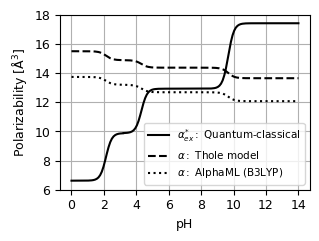

In [73]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8.3*cm, 6.3*cm))

# pka values for glutamic acid
pka = [2.13, 4.31, 9.67]

# Excess polarizability from GPAW
alpha_ex = np.array([6.6215, 9.8851, 12.9384, 17.4313])
plot_alpha_ph(alpha_ex, pka, k=2.8, color='k', linestyle='-', label='$α^{*}_{ex}:$ Quantum-classical', ax=ax1)

# Atomistic model
thole = [15.511, 14.897, 14.381, 13.657]
plot_alpha_ph(thole, pka, k=2.5, color='k', linestyle='--', label='$α:$ Thole model', ax=ax1)

# AlphaML
alphaml = read_alphaml_data('alphaml_b3lyp')
plot_alpha_ph(alphaml, pka, k=2.5, color='k', linestyle='dotted', label='$α:$ AlphaML (B3LYP)', ax=ax1)

ax1.set_ylabel('Polarizability [Å$^3$]')
ax1.set_xlabel('pH')
ax1.grid()
ax1.set_xticks(np.arange(0, 16, 2))
ax1.set_yticks(np.arange(6, 20, 2))

plt.rcParams.update({'font.size': 9})

plt.tight_layout()

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), ncol=1, fontsize='small')

#plt.savefig('glutamic_acid.svg', format='svg', dpi=1200, bbox_inches='tight')

# Make one big double column figure

Text(0.045, 0.972, 'e)')

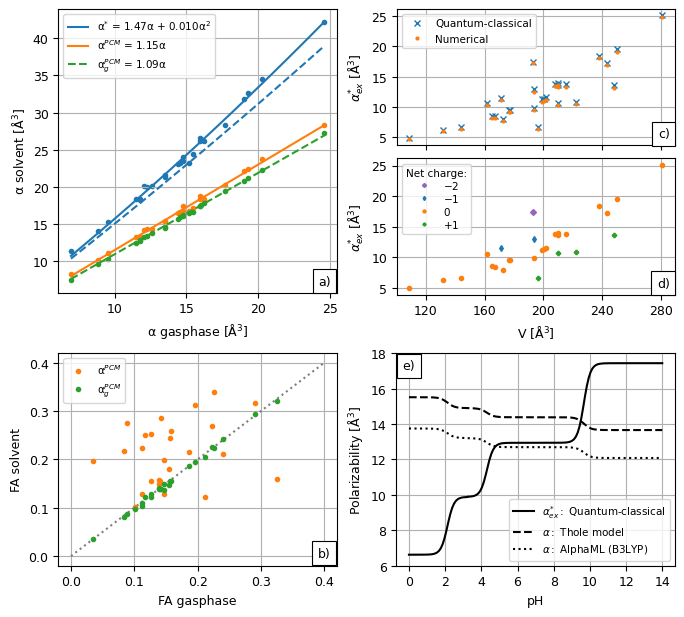

In [31]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(17.1*cm, 15.4*cm), constrained_layout=True)

gs = GridSpec(7, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:4, 0])
ax5 = fig.add_subplot(gs[4:7, 1])
ax2 = fig.add_subplot(gs[4:7, 0])

gs1 = gs[0:4, 1].subgridspec(2, 1)
axa = fig.add_subplot(gs1[0])
axb = fig.add_subplot(gs1[1])

# PLOT-A: polarizability
alpha_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[2])
gas_labels = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[0], dtype='str')
alpha_gas = alpha_gas[np.argsort(gas_labels)]

# gasphase structures in solvent
alpha_gas_pcm = filter_data('alpha_gas_pcm', gas_labels, usecols=[2])
# solvent structures in solvent
alpha_pcm = filter_data('alpha_pcm', gas_labels, usecols=[2])

# initial guess for self-consistent polarizability
alpha_initial = filter_data('alpha_local_field', gas_labels, usecols=[2])
# self-consistent polarizability results
alpha_converged = filter_data('alpha_local_field', gas_labels, usecols=[3])

# plot best fit lines
x = np.linspace(np.amin(alpha_gas), np.amax(alpha_gas), 50)
# converged
ax1.plot(x, 1.47167*x + 0.00987*x**2, label='α$^{*}$ = 1.47α + 0.010α$^{2}$', color='tab:blue')
# initial guess
ax1.plot(x, 1.44978*x + 0.00541*x**2, linestyle='--', color='tab:blue')
# alpha pcm (solvent structures)
ax1.plot(x, 1.14982*x, label='α$^{PCM}$ = 1.15α', color='tab:orange')
# alpha pcm (gasphase structures)
ax1.plot(x, 1.09385*x, label='α$^{PCM}_{g}$ = 1.09α', linestyle='--', color='tab:green')

# plot data
ax1.scatter(alpha_gas, alpha_converged, marker='.', color='tab:blue')
ax1.scatter(alpha_gas, alpha_pcm, marker='.', color='tab:orange')
ax1.scatter(alpha_gas, alpha_gas_pcm, marker='.', color='tab:green')

ax1.set_xticks(np.arange(10, 30, 5))
ax1.set_xlabel('α gasphase [Å$^3$]')
ax1.set_ylabel('α solvent [Å$^3$]')
ax1.legend(fontsize='small', ncol=1, markerscale=0.5)
ax1.grid()


# PLOT-B: fractional anisotropy
fa_gas = np.genfromtxt('./results/alpha_gas.dat', skip_header=2, usecols=[-1])
fa_gas = fa_gas[np.argsort(gas_labels)]

fa_gas_pcm = filter_data('alpha_gas_pcm', gas_labels, usecols=[-2])
fa_pcm = filter_data('alpha_pcm', gas_labels, usecols=[-2])

x = np.linspace(0, 0.4, 51)
ax2.plot(x, x, linestyle='dotted', color='tab:grey')
ax2.plot(fa_gas, fa_pcm, color='tab:orange', linestyle='', marker='.', label='α$^{PCM}$')
ax2.plot(fa_gas, fa_gas_pcm, color='tab:green', linestyle='', marker='.', label='α$^{PCM}_{g}$')

ax2.set_xlabel('FA gasphase')
ax2.set_ylabel('FA solvent')

ax2.set_yticks(np.arange(0, 0.5, 0.1))
ax2.set_xticks(np.arange(0, 0.5, 0.1))
ax2.legend(fontsize='small', ncol=1)
ax2.grid()

## PLOT-C: compare numerical model and hybrid quantum-classical model
cavity_volume = np.genfromtxt('./results/alpha_excess.dat', usecols=[-1], skip_header=2)
alpha_numerical = np.genfromtxt('./results/alpha_excess.dat', usecols=[2], skip_header=2)
alpha_excess = np.genfromtxt('./results/alpha_excess.dat', usecols=[3], skip_header=2)

axa.plot(cavity_volume, alpha_excess, label='Quantum-classical', marker='x', linestyle='', color='tab:blue', markersize=4)
axa.plot(cavity_volume, alpha_numerical, label='Numerical', marker='o', linestyle='', color='tab:orange', markersize=2)

axa.set_ylabel('$α^{*}_{ex}$ [Å$^3$]')
axa.grid()
axa.legend(fontsize='small')
axa.set_yticks(np.arange(5., 30., 5.))
axa.set_xticks(np.arange(120, 320., 40), labels=[])

# PLOT-D: amino acids catergorized according to net charge
net_charge = np.genfromtxt('./results/alpha_excess.dat', usecols=[1])
axb.plot(cavity_volume[net_charge==-2], alpha_excess[net_charge==-2], label='$-2$', marker='D', linestyle='', color='tab:purple', markersize=3)
axb.plot(cavity_volume[net_charge==-1], alpha_excess[net_charge==-1], label='$-1$', marker='d', linestyle='', color='tab:blue', markersize=3)
axb.plot(cavity_volume[net_charge==0], alpha_excess[net_charge==0], label='$0$', marker='o', linestyle='', color='tab:orange', markersize=3)
axb.plot(cavity_volume[net_charge==1], alpha_excess[net_charge==1], label='$+1$', marker='P', linestyle='', color='tab:green', markersize=3)

axb.grid()
axb.set_ylabel('$α^{*}_{ex}$ [Å$^3$]')
axb.set_xlabel('V [Å$^3$]')
axb.legend(title='Net charge:', fontsize='small', ncol=1, markerscale=0.7, title_fontsize='small', labelspacing=0.1)

axb.set_yticks(np.arange(5., 30., 5.))
axb.set_xticks(np.arange(120, 320., 40))


# PLOT-E: polarizability as a function of pH 

# pka values for glutamic acid
pka = [2.13, 4.31, 9.67]

# Excess polarizability from GPAW
alpha_ex = np.array([6.6215, 9.8851, 12.9384, 17.4313])
plot_alpha_ph(alpha_ex, pka, k=2.8, color='k', linestyle='-', label='$α^{*}_{ex}:$ Quantum-classical', ax=ax5)

# Atomistic model
thole = [15.511, 14.897, 14.381, 13.657]
plot_alpha_ph(thole, pka, k=2.5, color='k', linestyle='--', label='$α:$ Thole model', ax=ax5)

# AlphaML
alphaml = read_alphaml_data('alphaml_b3lyp')
plot_alpha_ph(alphaml, pka, k=2.5, color='k', linestyle='dotted', label='$α:$ AlphaML (B3LYP)', ax=ax5)

ax5.set_ylabel('Polarizability [Å$^3$]')
ax5.set_xlabel('pH')
ax5.grid()
ax5.set_xticks(np.arange(0, 16, 2))
ax5.set_yticks(np.arange(6, 20, 2))
ax5.legend(fontsize='small')

plt.rcParams.update({'font.size': 9})

# add labels

ax1.text(0.955, 0.063, 'a)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax1.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8))

ax2.text(0.954, 0.089, 'b)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax2.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8))

axa.text(0.96, 0.13, 'c)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axa.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8))

axb.text(0.958, 0.13, 'd)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axb.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8))
        
ax5.text(0.045, 0.972, 'e)',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax5.transAxes, 
        bbox=dict(facecolor='white', edgecolor='k', linewidth=0.8))

#plt.savefig('combined_image.svg', format='svg', dpi=1200, bbox_inches='tight')